# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [10]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

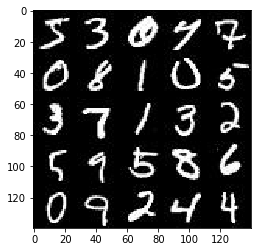

In [11]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

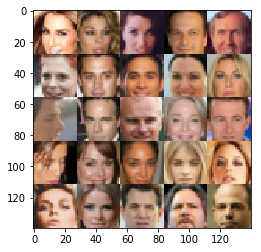

In [12]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Applications/anaconda/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [14]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,[None,image_width,image_height,image_channels],name='input_real')
    input_z = tf.placeholder(tf.float32,[None,z_dim],name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')

    return input_real,input_z,learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [25]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator',reuse=reuse):
        hidden_1 = tf.layers.conv2d(images,64,5,strides=2,padding='same',
                                   kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        hidden_1 = tf.maximum(alpha*hidden_1,hidden_1)
        # 14*14*64 now
        
        hidden_2 = tf.layers.conv2d(hidden_1,128,5,strides=2,padding='same',
                                   kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        hidden_2 = tf.layers.batch_normalization(hidden_2,training=True)
        hidden_2 = tf.maximum(alpha*hidden_2,hidden_2)
        # 7*7*128 now
        
        hidden_3 = tf.layers.conv2d(hidden_2,256,5,strides=1,padding='valid',
                                   kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        hidden_3 = tf.layers.batch_normalization(hidden_3,training=True)
        hidden_3 = tf.maximum(alpha*hidden_3,hidden_3)
        # 3*3*256 now
        
        # Flatten it
        flat = tf.reshape(hidden_3,(-1,3*3*256))
        
        # Fully connected layer
        logits = tf.layers.dense(flat,1)
        output = tf.sigmoid(logits)
    
    return logits,output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [26]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator',reuse=not is_train):
        # Fully connected layer
        hidden_1 = tf.layers.dense(z,3*3*256)
        # Reshape hidden_1
        hidden_1 = tf.reshape(hidden_1,(-1,3,3,256))
        # Apply batch normalization
        hidden_1 = tf.layers.batch_normalization(hidden_1,training=is_train)
        # Leaky RELU
        hidden_1 = tf.maximum(alpha*hidden_1,hidden_1)
        # 3*3*256 now
        
        hidden_2 = tf.layers.conv2d_transpose(hidden_1,128,5,strides=1,padding='valid',
                                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        hidden_2 = tf.layers.batch_normalization(hidden_2,training=is_train)
        hidden_2 = tf.maximum(alpha*hidden_2,hidden_2)
        # 7*7*128 now
        
        hidden_3 = tf.layers.conv2d_transpose(hidden_2,64,5,strides=2,padding='same',
                                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        hidden_3 = tf.layers.batch_normalization(hidden_3,training=is_train)
        hidden_3 = tf.maximum(alpha*hidden_3,hidden_3)
        # 14*14*64 now
        
        hidden_4 = tf.layers.conv2d_transpose(hidden_3,32,5,strides=2,padding='same',
                                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        hidden_4 = tf.layers.batch_normalization(hidden_4,training=is_train)
        hidden_4 = tf.maximum(alpha*hidden_4,hidden_4)
        # 28*28*32 now
        
        logits = tf.layers.conv2d_transpose(hidden_4,out_channel_dim,5,strides=1,padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # 28*28*out_channel_dim now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [27]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_out = generator(input_z,out_channel_dim)
    d_logits_real,output = discriminator(input_real)
    d_logits_fake,output = discriminator(g_out,reuse=True)
    
    # Generate labels
    label_ones = tf.ones_like(d_logits_real)
    label_zeros = tf.zeros_like(d_logits_fake)
    
    # Calculate the losses
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=label_ones))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=label_ones*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=label_zeros))
    d_loss = d_loss_real+d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Separate generator and discriminator variables
    var_t = tf.trainable_variables()
    var_g = [var for var in var_t if var.name.startswith('generator')]
    var_d = [var for var in var_t if var.name.startswith('discriminator')]
    
    # Optimization
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        train_opt_g = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss,
                                                                                              var_list=var_g)
        train_opt_d = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(d_loss,
                                                                                          var_list=var_d)
    
    return train_opt_g,train_opt_d


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [30]:
def train(epoch_count, batch_size, z_dim, lr, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param lr: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    if data_image_mode == 'RGB':
        out_channel_dim = 3
    elif data_image_mode == 'L':
        out_channel_dim = 1
    
    input_real,input_z,learning_rate = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    d_loss,g_loss = model_loss(input_real,input_z,out_channel_dim)
    train_opt_g,train_opt_d = model_opt(d_loss,g_loss,learning_rate,beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2.0
                steps += 1
                # Create input_z for the generator
                batch_z = np.random.uniform(-1,1,[batch_size,z_dim])
                
                _ = sess.run(train_opt_g,feed_dict={input_real:batch_images,input_z:batch_z,
                                                    learning_rate:lr})
                _ = sess.run(train_opt_d,feed_dict={input_real:batch_images,input_z:batch_z,
                                                    learning_rate:lr})
                
                # Print intermediate losses
                if steps%10 == 0:
                    train_loss_d = sess.run(d_loss,feed_dict={input_real:batch_images,input_z:batch_z})
                    train_loss_g = sess.run(g_loss,feed_dict={input_real:batch_images,input_z:batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                # Print intermediate figures
                if steps%100 == 0:
                    show_generator_output(sess,25,input_z,out_channel_dim,data_image_mode)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4957... Generator Loss: 13.1179
Epoch 1/2... Discriminator Loss: 0.4262... Generator Loss: 5.8576
Epoch 1/2... Discriminator Loss: 0.4228... Generator Loss: 8.0642
Epoch 1/2... Discriminator Loss: 0.7632... Generator Loss: 12.4116
Epoch 1/2... Discriminator Loss: 0.4005... Generator Loss: 6.0246
Epoch 1/2... Discriminator Loss: 0.9210... Generator Loss: 9.8185
Epoch 1/2... Discriminator Loss: 0.6020... Generator Loss: 9.1998
Epoch 1/2... Discriminator Loss: 0.4135... Generator Loss: 6.2872
Epoch 1/2... Discriminator Loss: 0.3773... Generator Loss: 4.3917
Epoch 1/2... Discriminator Loss: 0.4090... Generator Loss: 5.4837


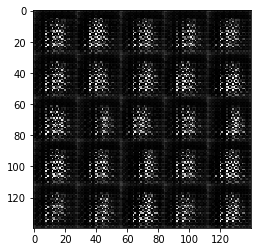

Epoch 1/2... Discriminator Loss: 0.5308... Generator Loss: 4.9734
Epoch 1/2... Discriminator Loss: 0.4184... Generator Loss: 4.6503
Epoch 1/2... Discriminator Loss: 0.5415... Generator Loss: 4.5720
Epoch 1/2... Discriminator Loss: 0.5899... Generator Loss: 4.3334
Epoch 1/2... Discriminator Loss: 0.6520... Generator Loss: 4.1275
Epoch 1/2... Discriminator Loss: 0.8278... Generator Loss: 3.5807
Epoch 1/2... Discriminator Loss: 0.6383... Generator Loss: 2.8743
Epoch 1/2... Discriminator Loss: 0.5840... Generator Loss: 3.0779
Epoch 1/2... Discriminator Loss: 0.7197... Generator Loss: 2.9539
Epoch 1/2... Discriminator Loss: 0.5931... Generator Loss: 2.6519


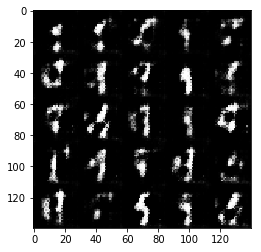

Epoch 1/2... Discriminator Loss: 0.8254... Generator Loss: 2.0097
Epoch 1/2... Discriminator Loss: 0.8479... Generator Loss: 2.6397
Epoch 1/2... Discriminator Loss: 0.7678... Generator Loss: 2.3105
Epoch 1/2... Discriminator Loss: 0.6913... Generator Loss: 1.6911
Epoch 1/2... Discriminator Loss: 0.7207... Generator Loss: 1.9508
Epoch 1/2... Discriminator Loss: 0.7094... Generator Loss: 2.0656
Epoch 1/2... Discriminator Loss: 1.0085... Generator Loss: 2.6988
Epoch 1/2... Discriminator Loss: 0.9105... Generator Loss: 2.4707
Epoch 1/2... Discriminator Loss: 0.9628... Generator Loss: 1.1174
Epoch 1/2... Discriminator Loss: 0.8581... Generator Loss: 1.4941


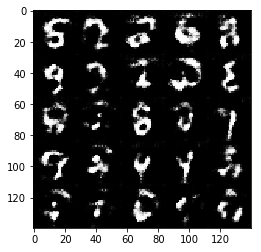

Epoch 1/2... Discriminator Loss: 0.7617... Generator Loss: 2.6351
Epoch 1/2... Discriminator Loss: 0.8174... Generator Loss: 1.7139
Epoch 1/2... Discriminator Loss: 0.6923... Generator Loss: 1.9658
Epoch 1/2... Discriminator Loss: 0.8303... Generator Loss: 1.6142
Epoch 1/2... Discriminator Loss: 0.8273... Generator Loss: 2.1932
Epoch 1/2... Discriminator Loss: 0.8447... Generator Loss: 1.4649
Epoch 1/2... Discriminator Loss: 0.9325... Generator Loss: 1.7463
Epoch 1/2... Discriminator Loss: 0.8592... Generator Loss: 1.8338
Epoch 1/2... Discriminator Loss: 0.9047... Generator Loss: 1.6608
Epoch 1/2... Discriminator Loss: 0.9183... Generator Loss: 1.3287


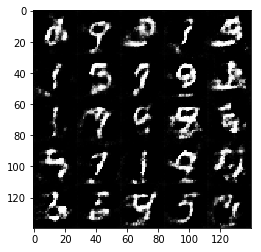

Epoch 1/2... Discriminator Loss: 0.9820... Generator Loss: 1.9424
Epoch 1/2... Discriminator Loss: 0.8253... Generator Loss: 1.4395
Epoch 1/2... Discriminator Loss: 1.0037... Generator Loss: 1.0177
Epoch 1/2... Discriminator Loss: 0.8694... Generator Loss: 1.6514
Epoch 1/2... Discriminator Loss: 0.7284... Generator Loss: 1.8551
Epoch 1/2... Discriminator Loss: 0.9109... Generator Loss: 1.7878
Epoch 1/2... Discriminator Loss: 0.9561... Generator Loss: 1.5201
Epoch 1/2... Discriminator Loss: 0.9248... Generator Loss: 1.6855
Epoch 1/2... Discriminator Loss: 0.9055... Generator Loss: 1.4983
Epoch 1/2... Discriminator Loss: 0.9113... Generator Loss: 1.6682


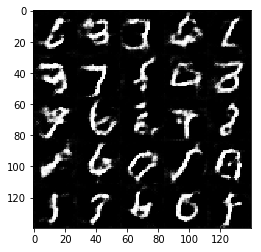

Epoch 1/2... Discriminator Loss: 1.1253... Generator Loss: 1.8969
Epoch 1/2... Discriminator Loss: 0.9027... Generator Loss: 1.2324
Epoch 1/2... Discriminator Loss: 1.0223... Generator Loss: 1.7701
Epoch 1/2... Discriminator Loss: 0.8921... Generator Loss: 1.7208
Epoch 1/2... Discriminator Loss: 0.9636... Generator Loss: 1.7522
Epoch 1/2... Discriminator Loss: 0.9982... Generator Loss: 1.8696
Epoch 1/2... Discriminator Loss: 1.2089... Generator Loss: 0.7343
Epoch 1/2... Discriminator Loss: 0.9513... Generator Loss: 1.1847
Epoch 1/2... Discriminator Loss: 0.9261... Generator Loss: 1.2510
Epoch 1/2... Discriminator Loss: 0.9756... Generator Loss: 1.8908


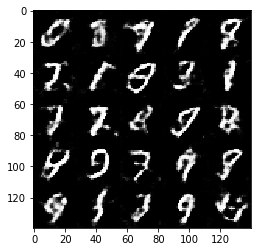

Epoch 1/2... Discriminator Loss: 0.9246... Generator Loss: 1.5476
Epoch 1/2... Discriminator Loss: 0.8681... Generator Loss: 1.7182
Epoch 1/2... Discriminator Loss: 0.8425... Generator Loss: 1.6635
Epoch 1/2... Discriminator Loss: 0.9140... Generator Loss: 1.2308
Epoch 1/2... Discriminator Loss: 0.9052... Generator Loss: 1.2196
Epoch 1/2... Discriminator Loss: 0.8611... Generator Loss: 1.3491
Epoch 1/2... Discriminator Loss: 0.9721... Generator Loss: 0.9950
Epoch 1/2... Discriminator Loss: 1.0516... Generator Loss: 1.3382
Epoch 1/2... Discriminator Loss: 0.9378... Generator Loss: 1.4446
Epoch 1/2... Discriminator Loss: 0.9938... Generator Loss: 2.0365


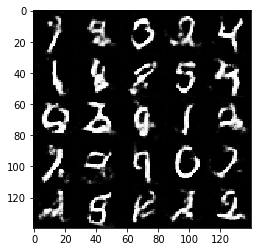

Epoch 1/2... Discriminator Loss: 0.8919... Generator Loss: 1.3781
Epoch 1/2... Discriminator Loss: 1.0025... Generator Loss: 0.9730
Epoch 1/2... Discriminator Loss: 0.8523... Generator Loss: 2.0977
Epoch 1/2... Discriminator Loss: 0.8506... Generator Loss: 1.9949
Epoch 1/2... Discriminator Loss: 0.7917... Generator Loss: 1.5318
Epoch 1/2... Discriminator Loss: 0.8070... Generator Loss: 1.6288
Epoch 1/2... Discriminator Loss: 0.8003... Generator Loss: 1.7123
Epoch 1/2... Discriminator Loss: 1.0572... Generator Loss: 0.8650
Epoch 1/2... Discriminator Loss: 0.9019... Generator Loss: 1.3208
Epoch 1/2... Discriminator Loss: 0.8754... Generator Loss: 1.5483


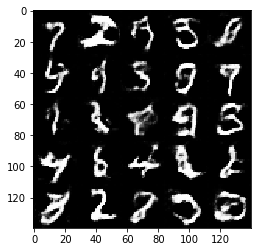

Epoch 1/2... Discriminator Loss: 0.9412... Generator Loss: 2.3844
Epoch 1/2... Discriminator Loss: 0.9997... Generator Loss: 2.7267
Epoch 1/2... Discriminator Loss: 1.0645... Generator Loss: 2.2572
Epoch 1/2... Discriminator Loss: 0.7162... Generator Loss: 1.9519
Epoch 1/2... Discriminator Loss: 0.8742... Generator Loss: 1.1615
Epoch 1/2... Discriminator Loss: 2.3196... Generator Loss: 0.2353
Epoch 1/2... Discriminator Loss: 1.0661... Generator Loss: 1.5782
Epoch 1/2... Discriminator Loss: 0.8291... Generator Loss: 1.5590
Epoch 1/2... Discriminator Loss: 0.8529... Generator Loss: 1.5654
Epoch 1/2... Discriminator Loss: 0.9356... Generator Loss: 1.7973


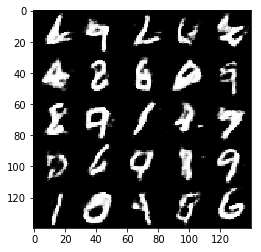

Epoch 1/2... Discriminator Loss: 0.8723... Generator Loss: 1.1779
Epoch 1/2... Discriminator Loss: 0.8507... Generator Loss: 1.3651
Epoch 1/2... Discriminator Loss: 0.8783... Generator Loss: 1.3966
Epoch 2/2... Discriminator Loss: 0.9744... Generator Loss: 0.9381
Epoch 2/2... Discriminator Loss: 0.9639... Generator Loss: 1.4041
Epoch 2/2... Discriminator Loss: 0.9064... Generator Loss: 1.6221
Epoch 2/2... Discriminator Loss: 0.8770... Generator Loss: 1.5293
Epoch 2/2... Discriminator Loss: 0.8232... Generator Loss: 1.4013
Epoch 2/2... Discriminator Loss: 0.9242... Generator Loss: 1.6044
Epoch 2/2... Discriminator Loss: 0.9774... Generator Loss: 1.4514


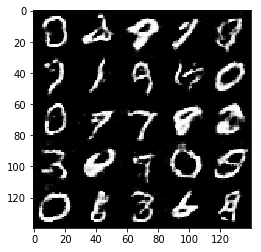

Epoch 2/2... Discriminator Loss: 0.8164... Generator Loss: 1.6388
Epoch 2/2... Discriminator Loss: 0.8741... Generator Loss: 1.3791
Epoch 2/2... Discriminator Loss: 0.8289... Generator Loss: 1.1296
Epoch 2/2... Discriminator Loss: 0.9256... Generator Loss: 1.3992
Epoch 2/2... Discriminator Loss: 1.0651... Generator Loss: 2.6030
Epoch 2/2... Discriminator Loss: 0.9527... Generator Loss: 1.7971
Epoch 2/2... Discriminator Loss: 0.9394... Generator Loss: 0.9624
Epoch 2/2... Discriminator Loss: 0.9609... Generator Loss: 1.0537
Epoch 2/2... Discriminator Loss: 0.8624... Generator Loss: 1.5864
Epoch 2/2... Discriminator Loss: 0.8112... Generator Loss: 1.5511


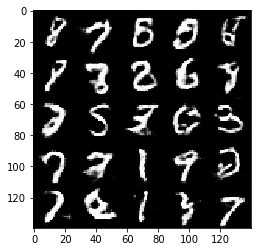

Epoch 2/2... Discriminator Loss: 0.9085... Generator Loss: 2.1924
Epoch 2/2... Discriminator Loss: 0.7849... Generator Loss: 1.8416
Epoch 2/2... Discriminator Loss: 0.8866... Generator Loss: 1.6075
Epoch 2/2... Discriminator Loss: 0.8189... Generator Loss: 1.7472
Epoch 2/2... Discriminator Loss: 0.9170... Generator Loss: 1.4158
Epoch 2/2... Discriminator Loss: 0.8944... Generator Loss: 1.5904
Epoch 2/2... Discriminator Loss: 0.8657... Generator Loss: 1.3879
Epoch 2/2... Discriminator Loss: 0.9231... Generator Loss: 1.1269
Epoch 2/2... Discriminator Loss: 0.8803... Generator Loss: 1.5900
Epoch 2/2... Discriminator Loss: 0.8245... Generator Loss: 1.2786


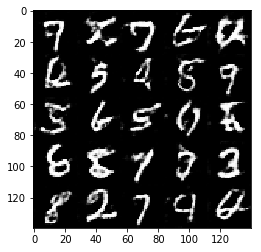

Epoch 2/2... Discriminator Loss: 0.7919... Generator Loss: 1.8955
Epoch 2/2... Discriminator Loss: 0.8290... Generator Loss: 1.6815
Epoch 2/2... Discriminator Loss: 0.9429... Generator Loss: 2.0018
Epoch 2/2... Discriminator Loss: 0.8287... Generator Loss: 1.3331
Epoch 2/2... Discriminator Loss: 0.9569... Generator Loss: 1.8091
Epoch 2/2... Discriminator Loss: 0.8161... Generator Loss: 1.8122
Epoch 2/2... Discriminator Loss: 0.9536... Generator Loss: 1.0411
Epoch 2/2... Discriminator Loss: 0.9124... Generator Loss: 1.1422
Epoch 2/2... Discriminator Loss: 0.7578... Generator Loss: 1.8545
Epoch 2/2... Discriminator Loss: 0.9493... Generator Loss: 0.9989


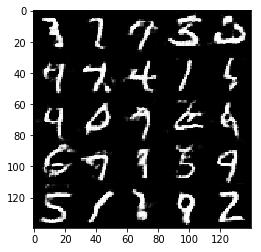

Epoch 2/2... Discriminator Loss: 0.8447... Generator Loss: 1.2758
Epoch 2/2... Discriminator Loss: 1.0025... Generator Loss: 1.1382
Epoch 2/2... Discriminator Loss: 0.9265... Generator Loss: 1.8446
Epoch 2/2... Discriminator Loss: 0.8625... Generator Loss: 1.8656
Epoch 2/2... Discriminator Loss: 0.9264... Generator Loss: 1.2197
Epoch 2/2... Discriminator Loss: 1.0561... Generator Loss: 0.8666
Epoch 2/2... Discriminator Loss: 0.8495... Generator Loss: 1.2920
Epoch 2/2... Discriminator Loss: 0.8130... Generator Loss: 1.8446
Epoch 2/2... Discriminator Loss: 0.9191... Generator Loss: 2.3273
Epoch 2/2... Discriminator Loss: 1.2047... Generator Loss: 2.6248


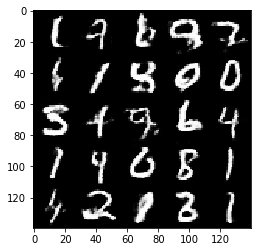

Epoch 2/2... Discriminator Loss: 1.5490... Generator Loss: 0.5434
Epoch 2/2... Discriminator Loss: 0.8859... Generator Loss: 1.7511
Epoch 2/2... Discriminator Loss: 0.9624... Generator Loss: 1.2189
Epoch 2/2... Discriminator Loss: 0.8341... Generator Loss: 1.5996
Epoch 2/2... Discriminator Loss: 0.8775... Generator Loss: 1.5478
Epoch 2/2... Discriminator Loss: 0.8719... Generator Loss: 1.5595
Epoch 2/2... Discriminator Loss: 0.8786... Generator Loss: 1.5727
Epoch 2/2... Discriminator Loss: 0.9230... Generator Loss: 1.3763
Epoch 2/2... Discriminator Loss: 0.8093... Generator Loss: 1.6004
Epoch 2/2... Discriminator Loss: 0.8157... Generator Loss: 1.9584


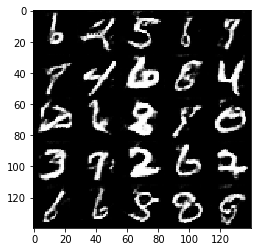

Epoch 2/2... Discriminator Loss: 0.9017... Generator Loss: 1.2896
Epoch 2/2... Discriminator Loss: 0.8497... Generator Loss: 2.3049
Epoch 2/2... Discriminator Loss: 0.8518... Generator Loss: 2.2191
Epoch 2/2... Discriminator Loss: 0.8719... Generator Loss: 1.9369
Epoch 2/2... Discriminator Loss: 0.9772... Generator Loss: 0.9856
Epoch 2/2... Discriminator Loss: 0.9649... Generator Loss: 1.9158
Epoch 2/2... Discriminator Loss: 0.9074... Generator Loss: 1.1984
Epoch 2/2... Discriminator Loss: 0.9387... Generator Loss: 2.0360
Epoch 2/2... Discriminator Loss: 0.9729... Generator Loss: 1.0450
Epoch 2/2... Discriminator Loss: 0.9805... Generator Loss: 1.7451


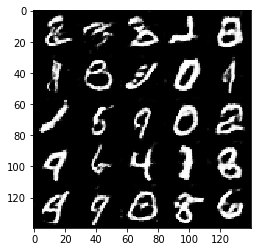

Epoch 2/2... Discriminator Loss: 0.8920... Generator Loss: 1.5669
Epoch 2/2... Discriminator Loss: 0.8400... Generator Loss: 1.4317
Epoch 2/2... Discriminator Loss: 0.8373... Generator Loss: 1.7307
Epoch 2/2... Discriminator Loss: 0.8593... Generator Loss: 1.5756
Epoch 2/2... Discriminator Loss: 0.8456... Generator Loss: 1.6634
Epoch 2/2... Discriminator Loss: 0.8472... Generator Loss: 1.7869
Epoch 2/2... Discriminator Loss: 0.8275... Generator Loss: 1.6204
Epoch 2/2... Discriminator Loss: 0.9079... Generator Loss: 2.0431
Epoch 2/2... Discriminator Loss: 0.9363... Generator Loss: 1.0917
Epoch 2/2... Discriminator Loss: 0.8864... Generator Loss: 1.2910


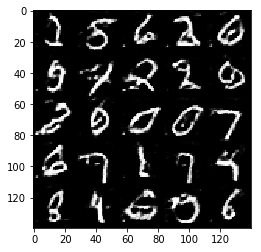

Epoch 2/2... Discriminator Loss: 0.9153... Generator Loss: 1.2610
Epoch 2/2... Discriminator Loss: 0.8912... Generator Loss: 1.6992
Epoch 2/2... Discriminator Loss: 0.9998... Generator Loss: 1.4530
Epoch 2/2... Discriminator Loss: 0.8400... Generator Loss: 1.5599
Epoch 2/2... Discriminator Loss: 1.0729... Generator Loss: 2.1847
Epoch 2/2... Discriminator Loss: 0.7282... Generator Loss: 1.5798
Epoch 2/2... Discriminator Loss: 0.7884... Generator Loss: 1.6979
Epoch 2/2... Discriminator Loss: 0.8757... Generator Loss: 1.3311
Epoch 2/2... Discriminator Loss: 0.8714... Generator Loss: 1.0419
Epoch 2/2... Discriminator Loss: 0.8394... Generator Loss: 1.5262


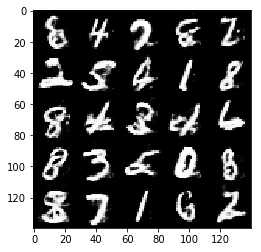

Epoch 2/2... Discriminator Loss: 0.8391... Generator Loss: 1.3601
Epoch 2/2... Discriminator Loss: 0.9159... Generator Loss: 1.3530
Epoch 2/2... Discriminator Loss: 0.8683... Generator Loss: 1.2111
Epoch 2/2... Discriminator Loss: 0.9182... Generator Loss: 1.4061
Epoch 2/2... Discriminator Loss: 0.9330... Generator Loss: 1.4969
Epoch 2/2... Discriminator Loss: 0.8790... Generator Loss: 1.9861
Epoch 2/2... Discriminator Loss: 0.8451... Generator Loss: 1.5485


In [31]:
batch_size = 64
z_dim = 100
lr = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, lr, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6419... Generator Loss: 13.0620
Epoch 1/1... Discriminator Loss: 0.4189... Generator Loss: 14.7990
Epoch 1/1... Discriminator Loss: 0.4533... Generator Loss: 14.7357
Epoch 1/1... Discriminator Loss: 0.4602... Generator Loss: 9.5624
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 16.9572
Epoch 1/1... Discriminator Loss: 0.4425... Generator Loss: 6.1875
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 9.8704
Epoch 1/1... Discriminator Loss: 0.5175... Generator Loss: 4.3312
Epoch 1/1... Discriminator Loss: 0.5866... Generator Loss: 4.8832
Epoch 1/1... Discriminator Loss: 0.4457... Generator Loss: 4.3195


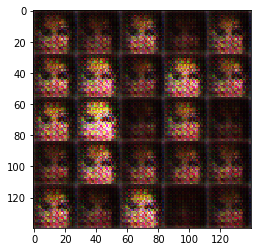

Epoch 1/1... Discriminator Loss: 2.1421... Generator Loss: 12.9222
Epoch 1/1... Discriminator Loss: 0.4579... Generator Loss: 3.5639
Epoch 1/1... Discriminator Loss: 0.4201... Generator Loss: 3.5768
Epoch 1/1... Discriminator Loss: 0.4191... Generator Loss: 8.0910
Epoch 1/1... Discriminator Loss: 0.4635... Generator Loss: 6.0949
Epoch 1/1... Discriminator Loss: 0.4504... Generator Loss: 5.0858
Epoch 1/1... Discriminator Loss: 0.4149... Generator Loss: 3.3454
Epoch 1/1... Discriminator Loss: 0.7470... Generator Loss: 4.6149
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 7.0123
Epoch 1/1... Discriminator Loss: 0.5274... Generator Loss: 3.0578


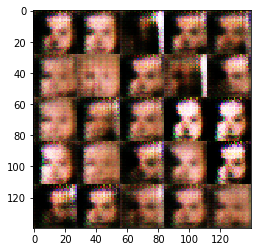

Epoch 1/1... Discriminator Loss: 0.6106... Generator Loss: 2.9978
Epoch 1/1... Discriminator Loss: 0.5892... Generator Loss: 2.7680
Epoch 1/1... Discriminator Loss: 0.8260... Generator Loss: 4.9315
Epoch 1/1... Discriminator Loss: 0.5038... Generator Loss: 2.6455
Epoch 1/1... Discriminator Loss: 0.5901... Generator Loss: 3.5645
Epoch 1/1... Discriminator Loss: 0.4367... Generator Loss: 3.3294
Epoch 1/1... Discriminator Loss: 0.7862... Generator Loss: 3.4853
Epoch 1/1... Discriminator Loss: 0.5945... Generator Loss: 3.5883
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 3.7053
Epoch 1/1... Discriminator Loss: 0.7522... Generator Loss: 3.7094


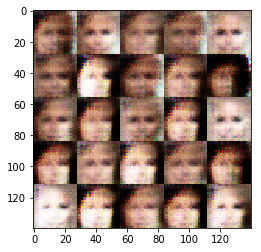

Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 5.5651
Epoch 1/1... Discriminator Loss: 0.5697... Generator Loss: 3.0855
Epoch 1/1... Discriminator Loss: 0.7426... Generator Loss: 3.9463
Epoch 1/1... Discriminator Loss: 0.4913... Generator Loss: 3.3179
Epoch 1/1... Discriminator Loss: 0.5034... Generator Loss: 2.8797
Epoch 1/1... Discriminator Loss: 0.4868... Generator Loss: 2.7016
Epoch 1/1... Discriminator Loss: 0.8343... Generator Loss: 3.8184
Epoch 1/1... Discriminator Loss: 0.6242... Generator Loss: 3.4527
Epoch 1/1... Discriminator Loss: 0.6701... Generator Loss: 3.3728
Epoch 1/1... Discriminator Loss: 0.6168... Generator Loss: 3.0751


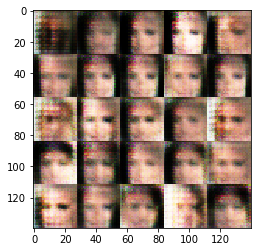

Epoch 1/1... Discriminator Loss: 0.7753... Generator Loss: 5.0376
Epoch 1/1... Discriminator Loss: 0.5565... Generator Loss: 3.4594
Epoch 1/1... Discriminator Loss: 0.6010... Generator Loss: 2.9730
Epoch 1/1... Discriminator Loss: 0.5406... Generator Loss: 2.5449
Epoch 1/1... Discriminator Loss: 0.5508... Generator Loss: 3.2301
Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 4.0218
Epoch 1/1... Discriminator Loss: 0.5538... Generator Loss: 2.9173
Epoch 1/1... Discriminator Loss: 0.7539... Generator Loss: 1.6639
Epoch 1/1... Discriminator Loss: 0.6478... Generator Loss: 3.0980
Epoch 1/1... Discriminator Loss: 0.8315... Generator Loss: 3.8819


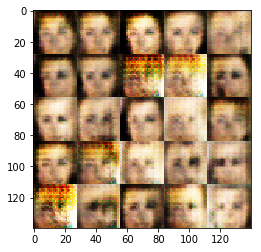

Epoch 1/1... Discriminator Loss: 0.7139... Generator Loss: 2.8153
Epoch 1/1... Discriminator Loss: 0.5747... Generator Loss: 3.8353
Epoch 1/1... Discriminator Loss: 0.5369... Generator Loss: 3.0479
Epoch 1/1... Discriminator Loss: 0.6038... Generator Loss: 3.0761
Epoch 1/1... Discriminator Loss: 0.6016... Generator Loss: 3.0593
Epoch 1/1... Discriminator Loss: 0.6310... Generator Loss: 2.5822
Epoch 1/1... Discriminator Loss: 0.6882... Generator Loss: 3.5105
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 5.0897
Epoch 1/1... Discriminator Loss: 0.7898... Generator Loss: 1.5415
Epoch 1/1... Discriminator Loss: 0.5834... Generator Loss: 2.5183


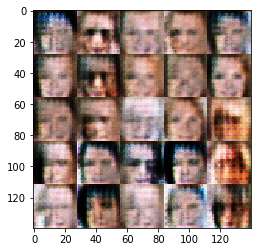

Epoch 1/1... Discriminator Loss: 0.6216... Generator Loss: 2.4370
Epoch 1/1... Discriminator Loss: 0.5336... Generator Loss: 3.5833
Epoch 1/1... Discriminator Loss: 0.8117... Generator Loss: 3.7568
Epoch 1/1... Discriminator Loss: 0.6846... Generator Loss: 2.4766
Epoch 1/1... Discriminator Loss: 0.7292... Generator Loss: 3.1386
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 4.4513
Epoch 1/1... Discriminator Loss: 0.7656... Generator Loss: 3.8192
Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 4.1968
Epoch 1/1... Discriminator Loss: 0.6373... Generator Loss: 2.8575
Epoch 1/1... Discriminator Loss: 0.6999... Generator Loss: 2.3753


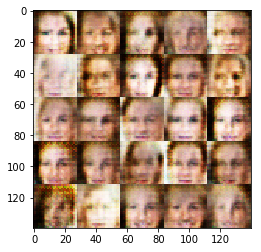

Epoch 1/1... Discriminator Loss: 0.7782... Generator Loss: 3.0769
Epoch 1/1... Discriminator Loss: 0.5815... Generator Loss: 2.8057
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 4.6691
Epoch 1/1... Discriminator Loss: 0.8430... Generator Loss: 3.8056
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 3.4325
Epoch 1/1... Discriminator Loss: 0.6991... Generator Loss: 2.2055
Epoch 1/1... Discriminator Loss: 0.5977... Generator Loss: 2.2901
Epoch 1/1... Discriminator Loss: 0.9315... Generator Loss: 3.6970
Epoch 1/1... Discriminator Loss: 0.8003... Generator Loss: 3.7983
Epoch 1/1... Discriminator Loss: 0.6186... Generator Loss: 2.2672


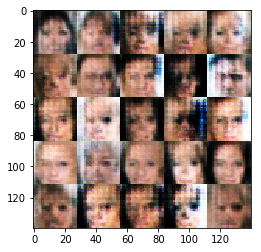

Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 3.0799
Epoch 1/1... Discriminator Loss: 0.7870... Generator Loss: 2.3329
Epoch 1/1... Discriminator Loss: 0.5732... Generator Loss: 2.4956
Epoch 1/1... Discriminator Loss: 0.6321... Generator Loss: 1.9022
Epoch 1/1... Discriminator Loss: 0.6592... Generator Loss: 1.9832
Epoch 1/1... Discriminator Loss: 0.7062... Generator Loss: 2.5614
Epoch 1/1... Discriminator Loss: 0.7891... Generator Loss: 3.4705
Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 2.6006
Epoch 1/1... Discriminator Loss: 0.7422... Generator Loss: 1.5269
Epoch 1/1... Discriminator Loss: 0.7480... Generator Loss: 2.4097


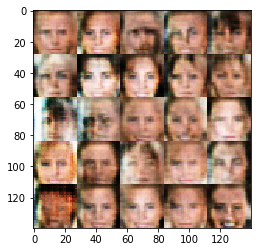

Epoch 1/1... Discriminator Loss: 0.6219... Generator Loss: 2.2002
Epoch 1/1... Discriminator Loss: 0.6295... Generator Loss: 2.8204
Epoch 1/1... Discriminator Loss: 0.6561... Generator Loss: 2.6113
Epoch 1/1... Discriminator Loss: 0.7198... Generator Loss: 2.3356
Epoch 1/1... Discriminator Loss: 0.5729... Generator Loss: 2.3968
Epoch 1/1... Discriminator Loss: 0.6672... Generator Loss: 1.9218
Epoch 1/1... Discriminator Loss: 0.5859... Generator Loss: 1.9576
Epoch 1/1... Discriminator Loss: 0.6755... Generator Loss: 2.3903
Epoch 1/1... Discriminator Loss: 0.7690... Generator Loss: 1.2936
Epoch 1/1... Discriminator Loss: 0.7955... Generator Loss: 2.4700


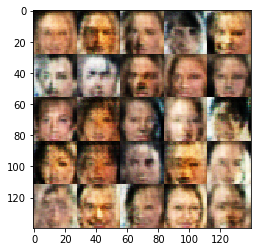

Epoch 1/1... Discriminator Loss: 0.6401... Generator Loss: 2.3565
Epoch 1/1... Discriminator Loss: 0.6700... Generator Loss: 2.0684
Epoch 1/1... Discriminator Loss: 0.6428... Generator Loss: 3.1033
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 3.6070
Epoch 1/1... Discriminator Loss: 0.6017... Generator Loss: 2.1931
Epoch 1/1... Discriminator Loss: 0.8428... Generator Loss: 3.1207
Epoch 1/1... Discriminator Loss: 0.6355... Generator Loss: 2.5060
Epoch 1/1... Discriminator Loss: 0.6586... Generator Loss: 1.7338
Epoch 1/1... Discriminator Loss: 0.6053... Generator Loss: 2.0969
Epoch 1/1... Discriminator Loss: 0.5907... Generator Loss: 2.3729


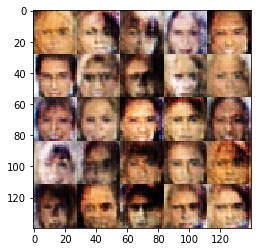

Epoch 1/1... Discriminator Loss: 0.7659... Generator Loss: 3.2954
Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 3.4527
Epoch 1/1... Discriminator Loss: 0.6163... Generator Loss: 2.4796
Epoch 1/1... Discriminator Loss: 0.7667... Generator Loss: 2.3660
Epoch 1/1... Discriminator Loss: 0.7147... Generator Loss: 1.7519
Epoch 1/1... Discriminator Loss: 0.6292... Generator Loss: 1.9226
Epoch 1/1... Discriminator Loss: 0.7776... Generator Loss: 2.2105
Epoch 1/1... Discriminator Loss: 0.6398... Generator Loss: 1.9860
Epoch 1/1... Discriminator Loss: 0.6059... Generator Loss: 2.3477
Epoch 1/1... Discriminator Loss: 0.5848... Generator Loss: 2.7092


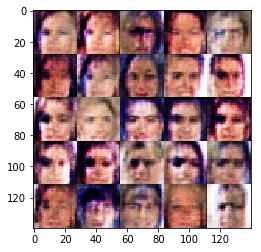

Epoch 1/1... Discriminator Loss: 0.7058... Generator Loss: 2.5693
Epoch 1/1... Discriminator Loss: 0.7139... Generator Loss: 1.7524
Epoch 1/1... Discriminator Loss: 0.8191... Generator Loss: 3.3773
Epoch 1/1... Discriminator Loss: 0.6210... Generator Loss: 2.3050
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 2.8349
Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 3.4648
Epoch 1/1... Discriminator Loss: 0.8358... Generator Loss: 1.1465
Epoch 1/1... Discriminator Loss: 0.6039... Generator Loss: 2.1699
Epoch 1/1... Discriminator Loss: 0.7869... Generator Loss: 2.9530
Epoch 1/1... Discriminator Loss: 0.5849... Generator Loss: 2.3396


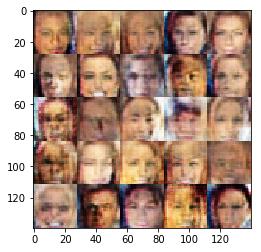

Epoch 1/1... Discriminator Loss: 0.6715... Generator Loss: 1.9050
Epoch 1/1... Discriminator Loss: 0.5980... Generator Loss: 2.8134
Epoch 1/1... Discriminator Loss: 0.9604... Generator Loss: 2.8908
Epoch 1/1... Discriminator Loss: 0.6763... Generator Loss: 2.1980
Epoch 1/1... Discriminator Loss: 0.7279... Generator Loss: 1.5024
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 3.3567
Epoch 1/1... Discriminator Loss: 0.7462... Generator Loss: 2.2168
Epoch 1/1... Discriminator Loss: 0.7049... Generator Loss: 1.7346
Epoch 1/1... Discriminator Loss: 0.6798... Generator Loss: 2.1097
Epoch 1/1... Discriminator Loss: 0.6543... Generator Loss: 2.2924


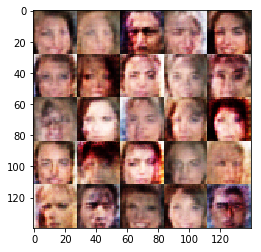

Epoch 1/1... Discriminator Loss: 0.7208... Generator Loss: 3.4564
Epoch 1/1... Discriminator Loss: 0.8675... Generator Loss: 3.2878
Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 3.4019
Epoch 1/1... Discriminator Loss: 0.7360... Generator Loss: 1.4867
Epoch 1/1... Discriminator Loss: 0.6073... Generator Loss: 2.0677
Epoch 1/1... Discriminator Loss: 0.6743... Generator Loss: 2.6049
Epoch 1/1... Discriminator Loss: 0.7107... Generator Loss: 2.5126
Epoch 1/1... Discriminator Loss: 0.6699... Generator Loss: 2.7482
Epoch 1/1... Discriminator Loss: 0.7774... Generator Loss: 3.1302
Epoch 1/1... Discriminator Loss: 0.6941... Generator Loss: 1.8497


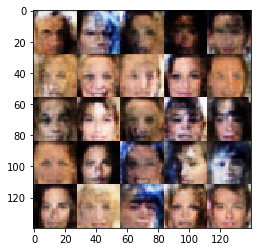

Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 3.6622
Epoch 1/1... Discriminator Loss: 0.7450... Generator Loss: 1.4159
Epoch 1/1... Discriminator Loss: 0.6150... Generator Loss: 2.5560
Epoch 1/1... Discriminator Loss: 0.7608... Generator Loss: 2.3476
Epoch 1/1... Discriminator Loss: 0.7594... Generator Loss: 2.4651
Epoch 1/1... Discriminator Loss: 0.6328... Generator Loss: 1.8608
Epoch 1/1... Discriminator Loss: 0.6576... Generator Loss: 2.8384
Epoch 1/1... Discriminator Loss: 0.6580... Generator Loss: 1.8115
Epoch 1/1... Discriminator Loss: 0.8171... Generator Loss: 2.8877
Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 3.5799


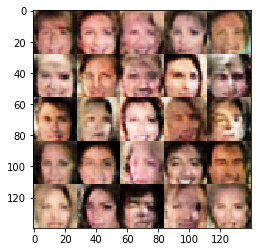

Epoch 1/1... Discriminator Loss: 0.8279... Generator Loss: 2.0096
Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 2.0278
Epoch 1/1... Discriminator Loss: 0.7419... Generator Loss: 1.3849
Epoch 1/1... Discriminator Loss: 0.8423... Generator Loss: 1.0950
Epoch 1/1... Discriminator Loss: 0.7242... Generator Loss: 1.5818
Epoch 1/1... Discriminator Loss: 0.7575... Generator Loss: 1.4441
Epoch 1/1... Discriminator Loss: 0.6798... Generator Loss: 2.2176
Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 2.8798
Epoch 1/1... Discriminator Loss: 0.5631... Generator Loss: 2.0456
Epoch 1/1... Discriminator Loss: 0.6863... Generator Loss: 1.7106


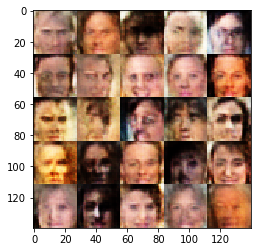

Epoch 1/1... Discriminator Loss: 0.7518... Generator Loss: 1.7242
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 3.3820
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 3.4785
Epoch 1/1... Discriminator Loss: 0.7091... Generator Loss: 1.9468
Epoch 1/1... Discriminator Loss: 0.6921... Generator Loss: 1.9823
Epoch 1/1... Discriminator Loss: 0.8666... Generator Loss: 2.4235
Epoch 1/1... Discriminator Loss: 0.7039... Generator Loss: 2.4675
Epoch 1/1... Discriminator Loss: 0.7853... Generator Loss: 2.7408
Epoch 1/1... Discriminator Loss: 0.7107... Generator Loss: 1.8627
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 0.8364


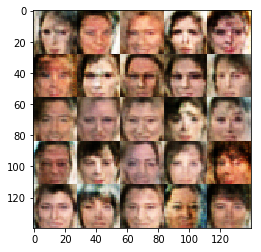

Epoch 1/1... Discriminator Loss: 0.7704... Generator Loss: 1.9289
Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 2.6380
Epoch 1/1... Discriminator Loss: 0.8108... Generator Loss: 2.6961
Epoch 1/1... Discriminator Loss: 0.8022... Generator Loss: 2.4446
Epoch 1/1... Discriminator Loss: 0.7406... Generator Loss: 1.4771
Epoch 1/1... Discriminator Loss: 0.6890... Generator Loss: 1.7290
Epoch 1/1... Discriminator Loss: 0.6846... Generator Loss: 1.5344
Epoch 1/1... Discriminator Loss: 0.7575... Generator Loss: 2.1056
Epoch 1/1... Discriminator Loss: 0.7117... Generator Loss: 1.9070
Epoch 1/1... Discriminator Loss: 0.8885... Generator Loss: 3.1798


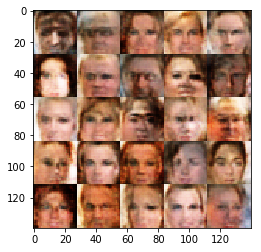

Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 2.0830
Epoch 1/1... Discriminator Loss: 0.7238... Generator Loss: 1.5374
Epoch 1/1... Discriminator Loss: 0.6988... Generator Loss: 1.6706
Epoch 1/1... Discriminator Loss: 0.7523... Generator Loss: 1.8118
Epoch 1/1... Discriminator Loss: 0.8878... Generator Loss: 1.0823
Epoch 1/1... Discriminator Loss: 0.7267... Generator Loss: 1.8405
Epoch 1/1... Discriminator Loss: 0.9089... Generator Loss: 1.1692
Epoch 1/1... Discriminator Loss: 0.6544... Generator Loss: 2.6119
Epoch 1/1... Discriminator Loss: 0.7023... Generator Loss: 1.9435
Epoch 1/1... Discriminator Loss: 0.7440... Generator Loss: 2.2082


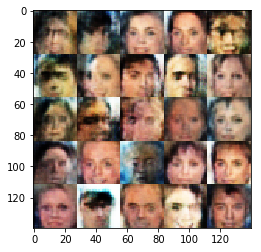

Epoch 1/1... Discriminator Loss: 0.7484... Generator Loss: 1.7377
Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 0.8170... Generator Loss: 1.3521
Epoch 1/1... Discriminator Loss: 0.8488... Generator Loss: 2.3016
Epoch 1/1... Discriminator Loss: 0.7516... Generator Loss: 2.1585
Epoch 1/1... Discriminator Loss: 0.9281... Generator Loss: 2.2389
Epoch 1/1... Discriminator Loss: 0.8271... Generator Loss: 1.4707
Epoch 1/1... Discriminator Loss: 0.7448... Generator Loss: 1.5993
Epoch 1/1... Discriminator Loss: 0.7712... Generator Loss: 1.2704
Epoch 1/1... Discriminator Loss: 0.7136... Generator Loss: 2.6776


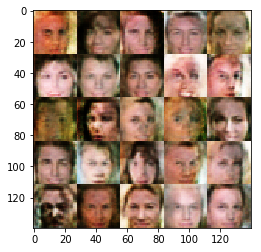

Epoch 1/1... Discriminator Loss: 0.8694... Generator Loss: 1.1073
Epoch 1/1... Discriminator Loss: 0.6737... Generator Loss: 1.8173
Epoch 1/1... Discriminator Loss: 0.7604... Generator Loss: 1.7575
Epoch 1/1... Discriminator Loss: 0.7219... Generator Loss: 1.5400
Epoch 1/1... Discriminator Loss: 0.7594... Generator Loss: 1.9363
Epoch 1/1... Discriminator Loss: 0.7731... Generator Loss: 1.9396
Epoch 1/1... Discriminator Loss: 0.7518... Generator Loss: 2.2165
Epoch 1/1... Discriminator Loss: 0.7698... Generator Loss: 2.0409
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 2.6468
Epoch 1/1... Discriminator Loss: 0.7067... Generator Loss: 1.8802


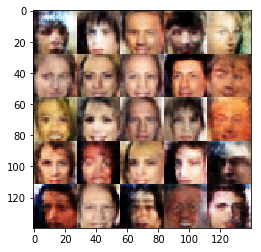

Epoch 1/1... Discriminator Loss: 0.7796... Generator Loss: 1.9613
Epoch 1/1... Discriminator Loss: 0.7395... Generator Loss: 2.6384
Epoch 1/1... Discriminator Loss: 0.8908... Generator Loss: 1.1391
Epoch 1/1... Discriminator Loss: 0.8132... Generator Loss: 2.1810
Epoch 1/1... Discriminator Loss: 0.8380... Generator Loss: 2.4352
Epoch 1/1... Discriminator Loss: 0.7254... Generator Loss: 1.7047
Epoch 1/1... Discriminator Loss: 0.7638... Generator Loss: 1.5207
Epoch 1/1... Discriminator Loss: 0.8018... Generator Loss: 2.5026
Epoch 1/1... Discriminator Loss: 0.9114... Generator Loss: 3.0366
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 3.5993


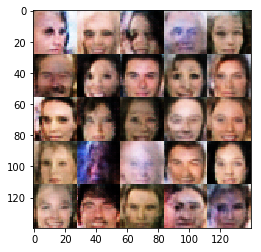

Epoch 1/1... Discriminator Loss: 0.7766... Generator Loss: 1.7183
Epoch 1/1... Discriminator Loss: 0.7205... Generator Loss: 1.7438
Epoch 1/1... Discriminator Loss: 0.7702... Generator Loss: 2.1678
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 1.1952
Epoch 1/1... Discriminator Loss: 0.6982... Generator Loss: 1.7453
Epoch 1/1... Discriminator Loss: 0.6754... Generator Loss: 2.0294
Epoch 1/1... Discriminator Loss: 0.7142... Generator Loss: 1.5036
Epoch 1/1... Discriminator Loss: 0.8167... Generator Loss: 2.4431
Epoch 1/1... Discriminator Loss: 0.7157... Generator Loss: 1.6633
Epoch 1/1... Discriminator Loss: 0.7566... Generator Loss: 1.3725


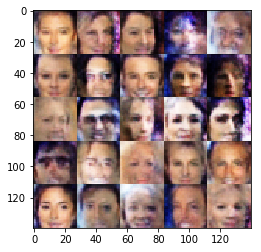

Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 2.9047
Epoch 1/1... Discriminator Loss: 0.9673... Generator Loss: 0.9041
Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 3.1135
Epoch 1/1... Discriminator Loss: 0.8326... Generator Loss: 1.8235
Epoch 1/1... Discriminator Loss: 0.7063... Generator Loss: 1.9975
Epoch 1/1... Discriminator Loss: 0.7992... Generator Loss: 2.4957
Epoch 1/1... Discriminator Loss: 0.8954... Generator Loss: 1.6107
Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 1.6491
Epoch 1/1... Discriminator Loss: 0.7101... Generator Loss: 2.3354
Epoch 1/1... Discriminator Loss: 0.7606... Generator Loss: 1.5249


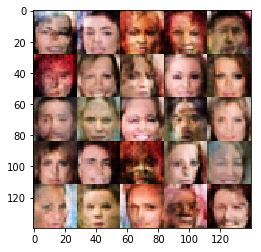

Epoch 1/1... Discriminator Loss: 0.7515... Generator Loss: 1.9436
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 2.9698
Epoch 1/1... Discriminator Loss: 0.6984... Generator Loss: 2.4712
Epoch 1/1... Discriminator Loss: 0.8838... Generator Loss: 2.6018
Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 1.1365
Epoch 1/1... Discriminator Loss: 0.8083... Generator Loss: 2.1744
Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 2.3016
Epoch 1/1... Discriminator Loss: 0.7534... Generator Loss: 1.4256
Epoch 1/1... Discriminator Loss: 0.7182... Generator Loss: 1.7388
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 0.8581


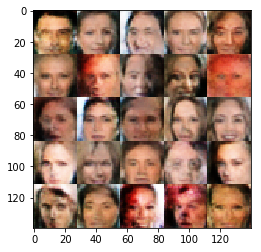

Epoch 1/1... Discriminator Loss: 0.7130... Generator Loss: 2.1563
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 2.3210
Epoch 1/1... Discriminator Loss: 0.7133... Generator Loss: 2.1801
Epoch 1/1... Discriminator Loss: 0.8939... Generator Loss: 2.7249
Epoch 1/1... Discriminator Loss: 0.7302... Generator Loss: 1.6503
Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 1.3089
Epoch 1/1... Discriminator Loss: 0.7689... Generator Loss: 2.2257
Epoch 1/1... Discriminator Loss: 0.7319... Generator Loss: 2.1907
Epoch 1/1... Discriminator Loss: 0.7294... Generator Loss: 1.9689
Epoch 1/1... Discriminator Loss: 0.8047... Generator Loss: 1.7591


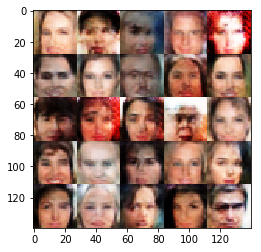

Epoch 1/1... Discriminator Loss: 0.8037... Generator Loss: 2.6518
Epoch 1/1... Discriminator Loss: 0.8929... Generator Loss: 1.0509
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 1.5824
Epoch 1/1... Discriminator Loss: 0.8405... Generator Loss: 1.9693
Epoch 1/1... Discriminator Loss: 0.7112... Generator Loss: 2.1777
Epoch 1/1... Discriminator Loss: 0.8420... Generator Loss: 2.0295
Epoch 1/1... Discriminator Loss: 0.8330... Generator Loss: 1.4125
Epoch 1/1... Discriminator Loss: 0.7107... Generator Loss: 1.8892
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 2.1940
Epoch 1/1... Discriminator Loss: 0.8363... Generator Loss: 2.6361


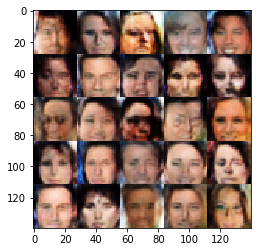

Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 1.1030
Epoch 1/1... Discriminator Loss: 0.7819... Generator Loss: 1.7121
Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 2.7279
Epoch 1/1... Discriminator Loss: 0.8020... Generator Loss: 1.6418
Epoch 1/1... Discriminator Loss: 0.9218... Generator Loss: 2.8798
Epoch 1/1... Discriminator Loss: 0.7297... Generator Loss: 2.0718
Epoch 1/1... Discriminator Loss: 0.8350... Generator Loss: 2.0314
Epoch 1/1... Discriminator Loss: 0.7368... Generator Loss: 2.2540
Epoch 1/1... Discriminator Loss: 0.7586... Generator Loss: 1.5939
Epoch 1/1... Discriminator Loss: 0.8066... Generator Loss: 2.0576


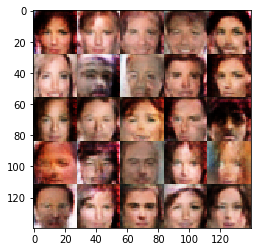

Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 2.1468
Epoch 1/1... Discriminator Loss: 0.8130... Generator Loss: 2.1185
Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 2.3396
Epoch 1/1... Discriminator Loss: 0.8280... Generator Loss: 1.7148
Epoch 1/1... Discriminator Loss: 0.7923... Generator Loss: 1.6065
Epoch 1/1... Discriminator Loss: 0.9442... Generator Loss: 2.8485
Epoch 1/1... Discriminator Loss: 0.7292... Generator Loss: 1.9713
Epoch 1/1... Discriminator Loss: 0.7630... Generator Loss: 1.7740
Epoch 1/1... Discriminator Loss: 0.8595... Generator Loss: 1.7126
Epoch 1/1... Discriminator Loss: 0.8913... Generator Loss: 1.0733


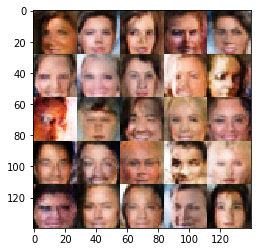

Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 2.2622
Epoch 1/1... Discriminator Loss: 0.8044... Generator Loss: 1.3081
Epoch 1/1... Discriminator Loss: 0.7243... Generator Loss: 1.6636
Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 1.2372
Epoch 1/1... Discriminator Loss: 0.7738... Generator Loss: 1.6092
Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 1.4868
Epoch 1/1... Discriminator Loss: 0.9321... Generator Loss: 1.9858
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 1.7410
Epoch 1/1... Discriminator Loss: 0.7715... Generator Loss: 1.6982
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 2.8881


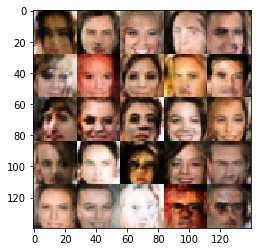

Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 1.1648
Epoch 1/1... Discriminator Loss: 0.8326... Generator Loss: 1.9735
Epoch 1/1... Discriminator Loss: 0.7811... Generator Loss: 2.2503
Epoch 1/1... Discriminator Loss: 0.7930... Generator Loss: 1.5964
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 0.9596
Epoch 1/1... Discriminator Loss: 0.8593... Generator Loss: 1.2401


In [32]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.